# Introduction

The three submetrics chosen for this analysis were housing price, arrests, and traffic. 

Housing price is an important indicator of the quality of a neighborhood. Generally, good neighborhoods tend to have higher home sale prices because the area is desirable and there is a high demand for a limited amount of housing. Economically, this shifts the balance of supply and demand onto the side of demand, which can dramatically drive up price. Housing price can be correlated with safety, quality of school districts, closeness to shops and activites, and generally the desirability of living in an area. 

Arrests generally indicate the crime that is present in a neighborhood and thereby the undesirability of the neighborhood. In the case of this analysis, fewer arrests will indicate a better neighborhood. 

Traffic can indicate the quality of a neighborhood. Generally, better neighborhoods will have many routes for traffic and commute times should be shorter than neighborhoods that are not concerned with city planning. This factor was normalized by dividing the total traffic by the size of the neighborhood. 

For the purposes of our overall analysis, the following normalizations were performed: 
~The mean housing price per neighborhood was divided by the highest priced neighborhood to yield a score out of 1
~The mean arrests were normalized by 1 - (arrests per unit area / highest arrests per unit area neighborhood). This yielded a total score out of 1 where the worst neighborhood received a 0. 
~Traffic was normalized similarly to arrests, by 1 - (traffic per unit area / highest arrests per unit area neighborhood). The worst neighborhood received a 0 of 1. 

Average housing price was weighted at 0.4. Arrests were weighted at 0.3. Traffic was weighted out of 0.3. This gave a score out of 1 using all 3 measures. This score was multiplied by 10 to give a final representative score out of a total of 10, as this is easier for readers to understand than a decimal value. 



           neighborhood  Average Home Sale Price  Housing Score  count  \
22           Friendship                 360000.0       0.848542    174   
49  Squirrel Hill North                 424257.0       1.000000    290   
42        Regent Square                 338350.0       0.797512     37   
30  Lower Lawrenceville                 274812.0       0.647749    272   
53       Strip District                 388000.0       0.914540    503   
25        Highland Park                 322875.0       0.761036    558   
16     Duquesne Heights                 220000.0       0.518554    191   
40         Point Breeze                 309130.0       0.728639    301   
13      Central Oakland                 277000.0       0.652906    521   
32          Morningside                 214362.0       0.505264    188   

    size_x  Normalized Crime  Arrest Score  average_daily_car_traffic  size_y  \
22   0.100       1740.000000      0.814777                     4887.0   0.100   
49   1.220        237.7

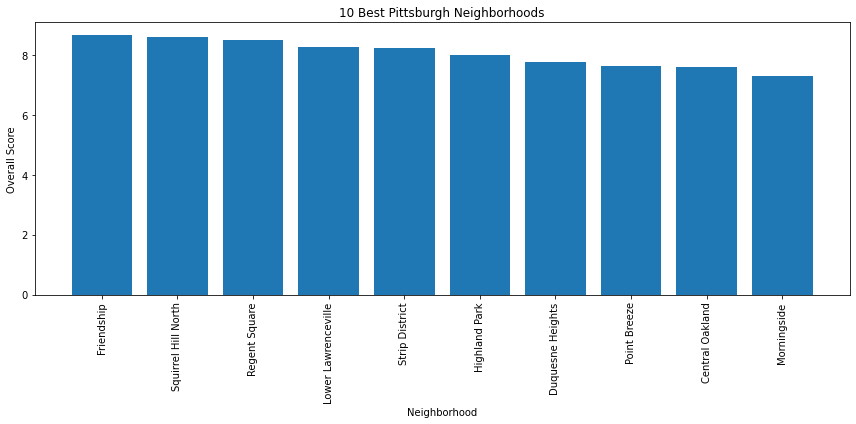

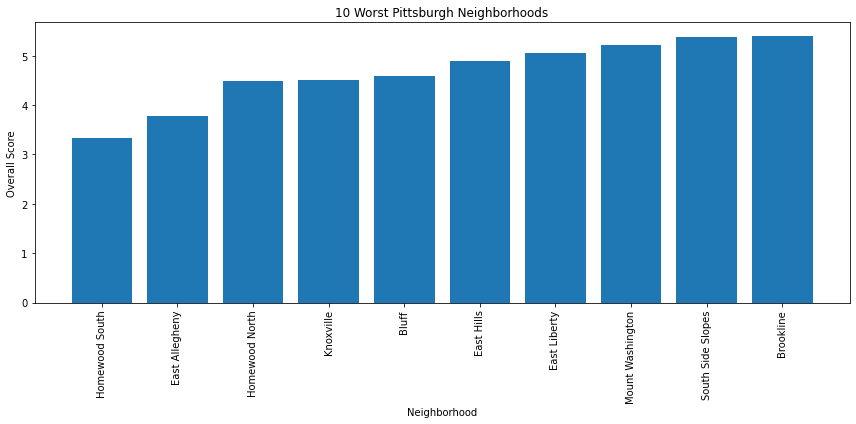

In [69]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapefile
from shapely.geometry import Point


#----------------------------------------------Housing Analysis-----------------------------------------------
#housing dataset that is imported as .shp file into geopandas
shp_file_path = "./PITT_MVA/Pitts_Allegheny_MVA2021.shp"
gdf = gpd.read_file(shp_file_path)

#test to see what is dropped from the gdf once 
#print(gdf["MSP1719"].nlargest(10))


#pittsburgh boundary that is imported as .shp file into geopandas
shp_file_path_2 = "./PGH_BOUND/City_Boundary.shp"
gdf_2 = gpd.read_file(shp_file_path_2)

#converted the mapping of latitude and longitude to the same formats
#intersection of data and boundary geopandas sets
gdf_2 = gdf_2.to_crs(gdf.crs)
intersection = gpd.overlay(gdf, gdf_2, how='intersection')

#will produce a dataframe containing just Pittsburgh data
df = intersection.drop(columns='geometry')


#got a file that converted the geoid data into Neighborhood data and merged with existing intersection df
df_geoid_cvt = pd.read_excel("Geoid to Neighborhood Map.xlsx")

#Cut geoid codes to 11 digits, as 12 digit codes include block number. Here, that granularity is not relevant
df['geoid_nb'] = df['geoid'].astype(str).str[:11]
df_geoid_cvt['geoid_nb'] = df_geoid_cvt['GEOID10'].astype(str).str[:11]

# Merge the DataFrames based on the new column containing the first 11 digits of the GeoID numbers
merged_df = pd.merge(df, df_geoid_cvt, on='geoid_nb', how="left")

#Cleaned the data of all unnecessary columns
merged_df = merged_df.drop(['geoid', 'VSP1719', 'FID', 'AREA_x', 'PERIMETER', 'BOUNDARY_', 'BOUNDARY_I', 'Shape_Leng',
                         'SHAPE_Le_1', 'SHAPE_Area', 'FID_BlockG', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLKGRPCE10',
                            'GEOID10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'FID_Neighb', 
                            'AREA_y', 'HOOD_NO', 'DPWDIV', 'UNIQUE_ID', 'SECTORS', 'Page_Numbe', 'ESRI_OID', 'NEIGHBOR_'], axis=1)


merged_df = merged_df.rename(columns={'MSP1719': 'Median Home Sale Price', 'PHHOO': ' Percent Owner Occupied', 
                                      'PROSubHH': 'Percent Subsidy Recipients', 'pforc1719': 'Percent Foreclosures', 'pVacLot': 'Percent Vacant Lots',
                                      'pViolAddress': 'Percent Housing Violations', 'pcond_flag' : 'Percent Parcels in Poor Condition', 'MVA21' : 'Letter Grade Assessment', 'HOOD' : "neighborhood"})
    

#print(merged_df.head(10))

#top_30_values = merged_df.nlargest(30, 'Median Home Sale Price')
#print(top_30_values)

#naive solution printing only the census tracts with the largest housing sale price


#Note, this data is from the 2017-2019 Census when Lawrenceville was not as popular
average = merged_df.groupby('neighborhood')['Median Home Sale Price'].mean()
average_df = average.reset_index()
average_df.columns = ['neighborhood', 'Average Home Sale Price']
average_df['Average Home Sale Price'] = average_df["Average Home Sale Price"].round(0)
average_df = average_df[average_df['Average Home Sale Price'] > 0]
average_df["Housing Score"] = average_df["Average Home Sale Price"] / average_df["Average Home Sale Price"].max()

#Normalized
housing = average_df

#-----------------------------------------End Housing Analysis-----------------------------------
#---------------------------------------------------Arrest Analysis------------------------------------------

# Load the arrest data
arrests = pd.read_csv('arrests.csv')

# Clean and preprocess the data
arrests = arrests.dropna(subset=['INCIDENTNEIGHBORHOOD'])  # Drop rows with missing neighborhood

# Load the neighborhood sizes data
neighborhood_sizes = pd.read_csv('miles.csv')

# Replace 0 values in the 'size' column with 1 to avoid division by zero
neighborhood_sizes['size'] = neighborhood_sizes['size'].replace(0, 1)


# Group the arrest data by neighborhood and count the total arrests
neighborhood_counts = arrests['INCIDENTNEIGHBORHOOD'].value_counts().reset_index()
neighborhood_counts.columns = ['neighborhood', 'count']


crime = pd.merge(neighborhood_counts, neighborhood_sizes, on='neighborhood', how="inner")
crime = crime[crime["size"].notna()]
crime["Normalized Crime"] = crime["count"] / crime["size"]

#Normalized
crime["Arrest Score"] = 1 - (crime["Normalized Crime"] / crime["Normalized Crime"].max())



#----------------------------------End arrest analysis---------------------------------------

#----------------------------------Traffic Analysis-----------------------------------------

#read in the file, add together all the traffic from different neighborhoods
data= pd.read_csv("pittTraffic.csv", usecols=["neighborhood", "average_daily_car_traffic"])
data = data[data['average_daily_car_traffic']>0]
total_data = data.groupby('neighborhood')['average_daily_car_traffic'].sum()

#read in size data for neighborhoods
sizedata= pd.read_csv("miles.csv", usecols=["neighborhood", "size"])
sizedata= sizedata[sizedata['size']>0]

#merge the dataframes together and normalize traffic by total traffic / size of neighborhood
traffic = pd.merge(total_data, sizedata, on='neighborhood', how="inner")
traffic["Normalized Traffic"] = traffic["average_daily_car_traffic"] / traffic["size"]
traffic["Traffic Score"] = 1 - (traffic["average_daily_car_traffic"] / traffic["average_daily_car_traffic"].max())

#-----------------------End Traffic Analysis------------------------------------------------------

#----------------------------Scoring Overall ------------------------------------------------
temp_df = pd.merge(housing, crime, on='neighborhood', how="inner")
conclusion_df = pd.merge(temp_df, traffic, on="neighborhood", how="inner")
conclusion_df["Overall Score"] = (conclusion_df["Housing Score"] * 0.4 + conclusion_df["Arrest Score"] * 0.3 + conclusion_df["Traffic Score"] * 0.3) * 10
best_neighborhoods = conclusion_df.nlargest(10, ["Overall Score"])
worst_neighborhoods = conclusion_df.nsmallest(10, ["Overall Score"])

print(best_neighborhoods.head(10))

plt.figure(figsize=(12, 6))
plt.bar(best_neighborhoods["neighborhood"], best_neighborhoods["Overall Score"])
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('Overall Score')
plt.title("10 Best Pittsburgh Neighborhoods")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(worst_neighborhoods["neighborhood"], worst_neighborhoods["Overall Score"])
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('Overall Score')
plt.title("10 Worst Pittsburgh Neighborhoods")
plt.tight_layout()
plt.show()


# Code Summary 

The code summaries can be viewed in the individual notebook files. There are some slight modifications here to make the analysis easier and to utilize similar tools. 


    -

# Analysis

The data when normalized and weighted 40% by housing value, 30% by traffic, and 30% by arrests shows that Friendship is the best neighborhood with a score of 8.65/10 and this is closely followed by Squirrel Hill North at 8.5/10 and Regent Square at 8.5/10. This tracks with what other groups have presented but other groups did not usually find Friendship to be the best neighborhood overall. It is in my opinion due to its safety, friendliness and low population. 

The worst neighborhood came out to be Homewood South with a score a little less than 3.5/10. Easy Allengheny and Homewood South followed closely with scores less than 5. This is likely because housing is cheap in these areas and arrests are high.